# Initial Data Reading

In this notebook the data is explored. We check the layout of the fiber and drop possibly unfit data. Then an initial visualization is made of the section of time corresponding to an earthquake.

In [1]:
import pandas as pd
from das_fk.utils import read_PASSCAL_segy, downsample_das
from das_fk.visualization import show_data
import matplotlib.pyplot as plt

# Download data

In [2]:
# from 
# !pip3 install awscli


In [3]:
# download locations csv
# !cd ../data && aws s3 cp --no-sign-request s3://scedc-pds/Ridgecrest_DAS/das_info.csv .

In [4]:
# download a single file
# !cd ../data && aws s3 cp --no-sign-request s3://scedc-pds/Ridgecrest_DAS/SEG-Y/hourly/2020062417.segy .

# Channel positions

In [5]:
location = pd.read_csv("../data/das_info.csv")
location.head()

,index,latitude,longitude,elevation_m
0,25,35.645200,-117.667931,0.0
1,26,35.645272,-117.667929,0.0
2,27,35.645344,-117.667928,0.0
3,28,35.645416,-117.667927,0.0
4,29,35.645488,-117.667926,0.0


In [6]:
import folium
def plot_map(location: pd.DataFrame) -> folium.Map      :
    center = [location.latitude.mean(), location.longitude.mean()]
    my_map = folium.Map(location=center, zoom_start=12, tiles='Stamen Terrain')
    folium.PolyLine(location[['latitude', 'longitude']].values.tolist(),
                    color="red", weight=2.5, opacity=1).add_to(my_map)
    title_html = '''
                    <h3 align="center" style="font-size:20px"><b>{}</b></h3>    
                    '''.format("Ridgecrest DAS")
    my_map.get_root().html.add_child(folium.Element(title_html))
    my_map.options['scrollWheelZoom'] = False
    return my_map

my_map = plot_map(location)
my_map

The fiber is placed next to a road. This means that the data is going to be filled with human made coherent noise. Furthermore, the last piece has some sharp bends, and a perpendicular direction.

Text(0.5, 1.0, 'Index of the DAS data')

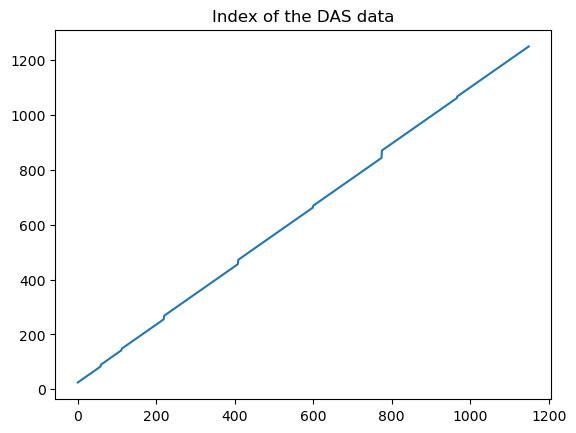

In [7]:
location["index"].plot()
plt.title("Index of the DAS data")

Seems like there are multiple sections of points that are dropped. Probably
these have noisy data because of poor coupling, and where in consequence dropped.

Text(0.5, 1.0, 'Index vs. Elevation')

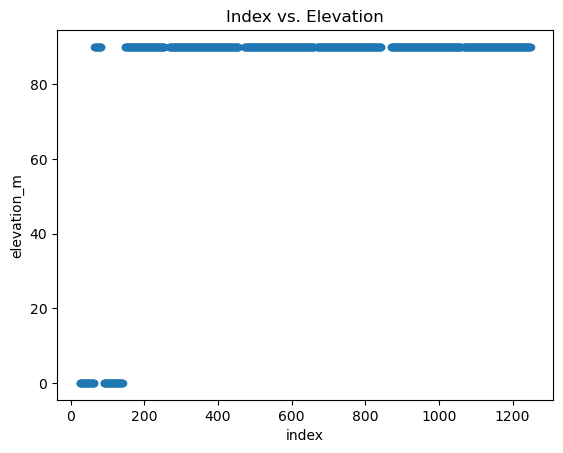

In [8]:
location.plot.scatter("index", "elevation_m")
plt.title("Index vs. Elevation")

Elevation data is suspicious, why would everything be on a fixed 80 meter elevation while the rest is on zero meters?

In [9]:
location_new = location[120:]

The first section corresponds to the small perpendicular section to the right. This will be dropped, and in this manner we evade the effects of different altitude and different direction.

In [10]:
my_map = plot_map(location_new)
my_map

# Preprocess

In [11]:
channel_index = location_new["index"].to_numpy()
channel_lat = location_new["latitude"].to_numpy()
channel_lon = location_new["longitude"].to_numpy()

In [12]:
data, das_time = read_PASSCAL_segy("../data/2020062417.segy")

In [13]:
# Option 1: Downsample the data.
strain, das_time = downsample_das(data[channel_index, :], das_time, fd=10)
strain.shape

# Option 2: Don't downsample
# strain = data[channel_index, :]

# Option 3: Don't downsample and keep all channels
# strain = data

(1030, 36000)

In [14]:
# Highpass filter
from scipy.signal import butter, sosfiltfilt

dt = das_time[1] - das_time[0] # (it is constant)
sos = butter(4, 0.5*2*dt, output='sos', btype='high')
strain_filt = sosfiltfilt(sos, strain, axis=1)

# Median filter
# For salt and pepper noise, outliers and bad channels.
from scipy.signal import medfilt2d

strain_prep = medfilt2d(strain_filt, kernel_size=(5,1))

# Visualize

Text(0.5, 1.0, 'High-passed Strain')

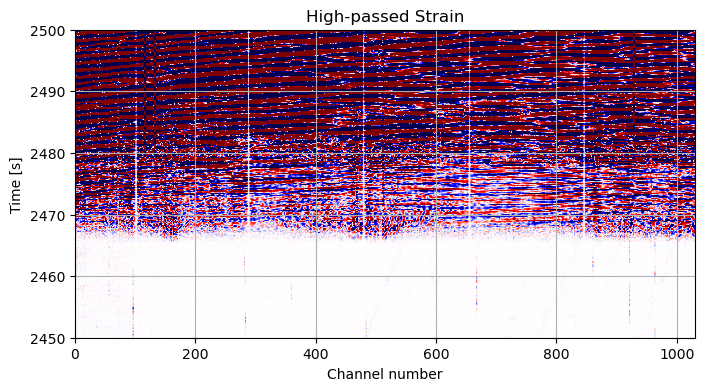

In [ ]:
fig, ax2 = show_data(strain_prep, das_time, pclip=98)
ax2.set_ylim(2450, 2500)
ax2.set_title('High-passed & median filtered Strain')